# **Personal Simulation Project**
### Credit Card Fraud Detection
### By Kay Pham

It's Sunday morning, it's quiet and you wake up with a big smile on your face. Today is going to be a great day! Except, your phone rings, rather "internationally". You pick it up slowly and hear something really bizarre - "Bonjour, je suis Michele. Oops, sorry. I am Michele, your personal bank agent.". What could possibly be so urgent for someone from Switzerland to call you at this hour? "Did you authorize a transaction for $3,358.65 for 100 copies of Diablo 3?" Immediately, you start thinking of ways to explain why you did that to your loved one. "No, I didn't !?". Michele's answer is quick and to the point - "Thank you, we're on it". Whew, that was close! But how did Michele knew that this transaction was suspicious? After all, you did order 10 new smartphones from that same bank account, last week - Michele didn't call then.


Annual global fraud losses reached $21.8 billion in 2015, according to the Nilson Report.

Probably you feel very lucky if you are a fraud. About every 12 cents per $100 were stolen in the US during the same year. Our friend Michele might have a serious problem to solve here.

In this part of the series, I will train an Autoencoder Neural Network (implemented in Keras) in unsupervised (or semi-supervised) fashion for Anomaly Detection in credit card transaction data. The trained model will be evaluated on pre-labeled and anonymized dataset.

In [2]:
pip install tensorflow

   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/332.0 MB 2.4 MB/s eta 0:02:17
   ---------------------------------------- 1.6/332.0 MB 3.1 MB/s eta 0:01:48
   ---------------------------------------- 2.4/332.0 MB 3.3 MB/s eta 0:01:40
   ---------------------------------------- 2.6/332.0 MB 2.8 MB/s eta 0:01:58
   ---------------------------------------- 2.9/332.0 MB 2.6 MB/s eta 0:02:08
   ---------------------------------------- 3.7/332.0 MB 2.7 MB/s eta 0:02:02
   ---------------------------------------- 3.9/332.0 MB 2.5 MB/s eta 0:02:10
    --------------------------------------- 4.5/332.0 MB 2.5 MB/s eta 0:02:10
    --------------------------------------- 5.2/332.0 MB 2.7 MB/s eta 0:02:03
    --------------------------------------- 5.8/332.0 MB 2.7 MB/s eta 0:02:03
    --------------------------------------- 7.1/332.0 MB 2.9 MB/s eta 0:01:52


In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

D:\Anaconda\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Loading The Data

The dataset is from Kaggle (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset

The dataset is from Kaggle. It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [9]:
df = pd.read_csv("C:/Users/khiem/Downloads/creditcard.csv")

# Exploration

In [11]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [12]:
df.isnull().values.any()

np.False_

C:\Users\khiem\AppData\Local\Temp\ipykernel_3580\2107955042.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


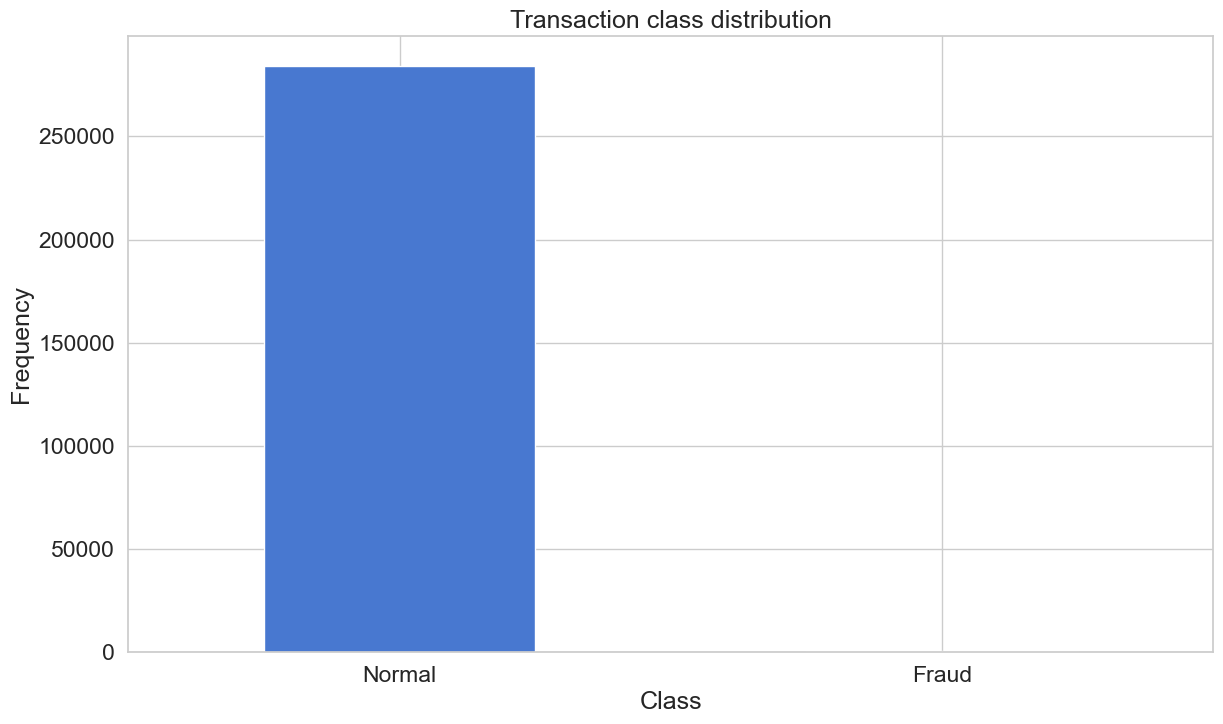

In [13]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

I have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions:

In [14]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [15]:
frauds.shape

(492, 31)

In [16]:
normal.shape

(284315, 31)

How different are the amount of money used in different transaction classes?

In [17]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [18]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Let's have a more graphical representation:

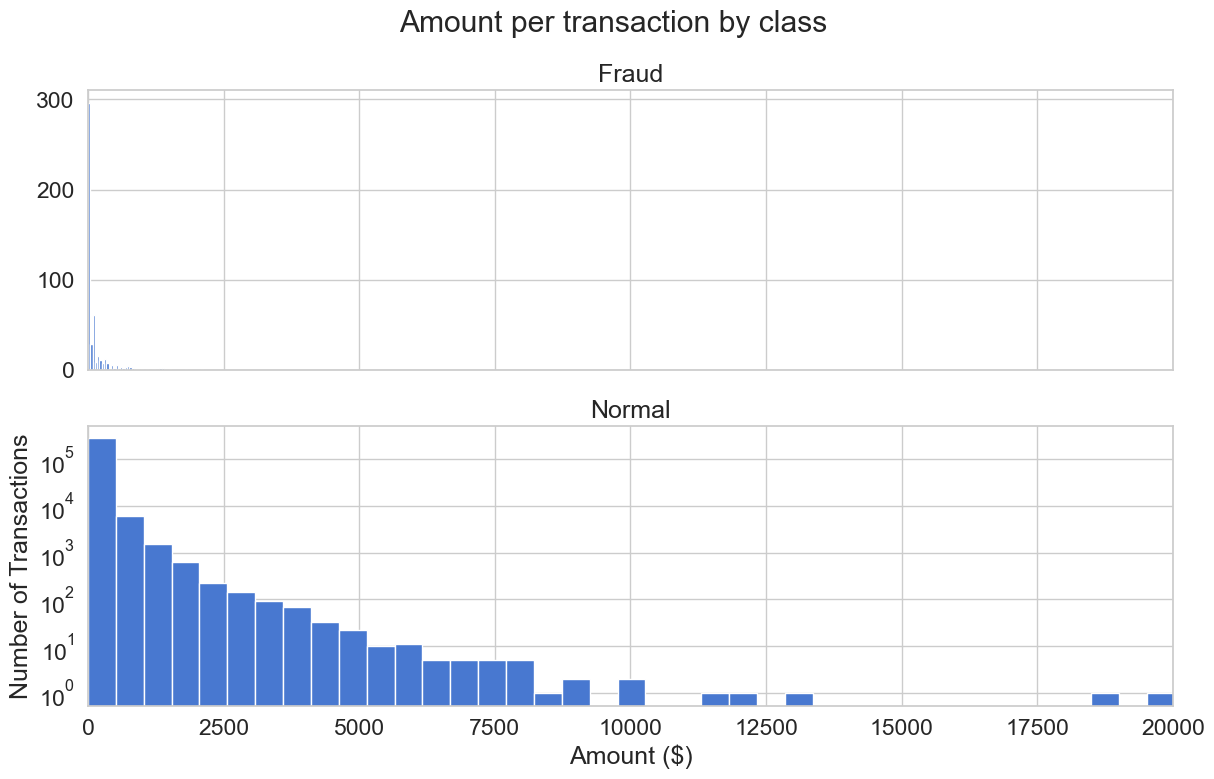

In [19]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Do fraudulent transactions occur more often during certain time?

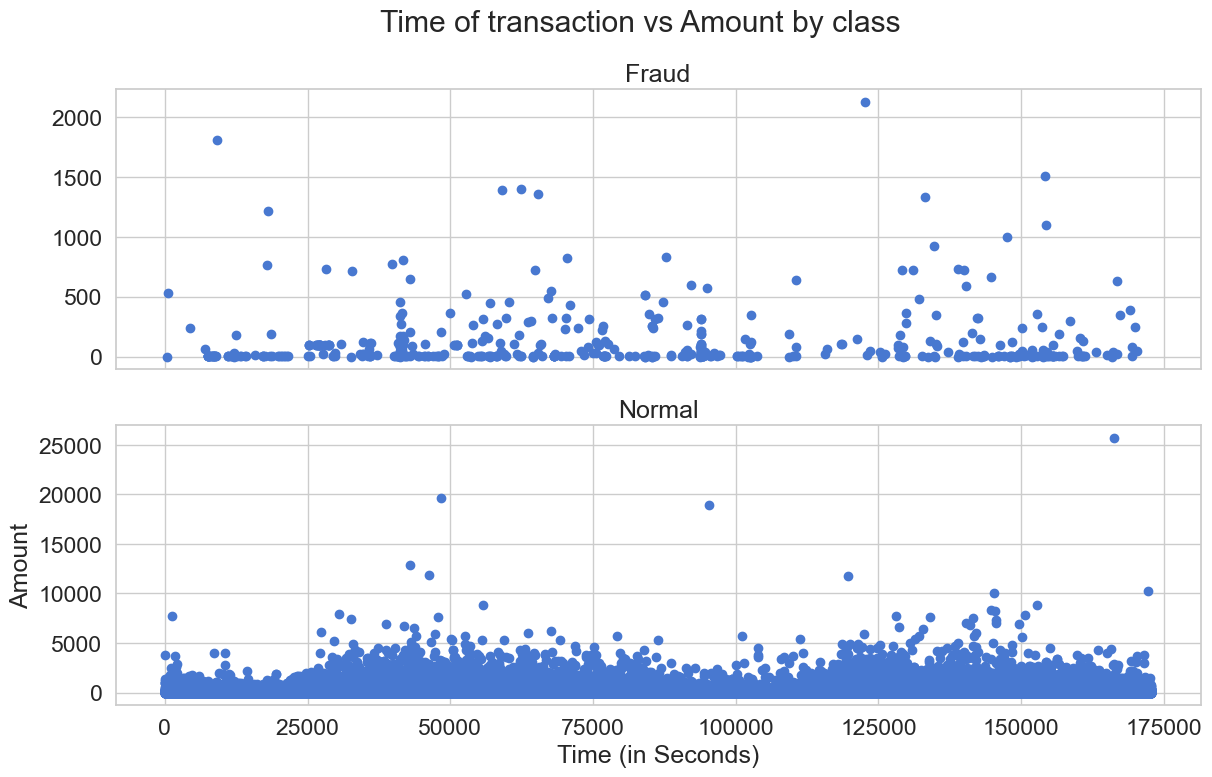

In [20]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Doesn't seem like the time of transaction really matters.

# Autoencoders

Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. Puzzling? Definitely was for me, the first time I heard it.

While trying to do just that might sound trivial at first, it is important to note that I want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called undercomplete.

# Reconstruction error

I optimize the parameters of our Autoencoder model in such way that a special kind of error - reconstruction error is minimized.

If you want to learn more about Autoencoders I highly recommend the following videos by Hugo Larochelle.

# Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [5]:
import pandas as pd

df = pd.read_csv(r"C:\Users\khiem\Downloads\creditcard.csv")

In [6]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(
    data['Amount'].values.reshape(-1, 1)
)

Training our Autoencoder is gonna be a bit different from what I am used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. I will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. I will reserve 20% of our data for testing:

In [8]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

X_train, X_test = train_test_split(
    data,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=data['Class']  # optional but recommended
)

X_train = X_train[X_train['Class'] == 0]
X_train = X_train.drop(columns=['Class'])

y_test = X_test['Class']
X_test = X_test.drop(columns=['Class'])

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [9]:
X_train.shape

(227451, 29)

# Building the model

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [11]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [15]:
input_dim = X_train.shape[1]      
encoding_dim = 14                 

input_layer = Input(shape=(input_dim,))

x = Dense(
    encoding_dim,
    activation="tanh",
    activity_regularizer=regularizers.l1(1e-4)
)(input_layer)
x = Dense(encoding_dim // 2, activation="relu")(x)

x = Dense(encoding_dim // 2, activation="tanh")(x)
output_layer = Dense(input_dim, activation="relu")(x)

autoencoder = Model(inputs=input_layer, outputs=output_layer)

autoencoder.compile(optimizer="adam", loss="mse")

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally, the training progress will be exported in a format that TensorBoard understands.

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard  # Added import for callbacks
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers  # Added import for regularizers

input_dim = X_train.shape[1]
encoding_dim = 32  

input_layer = Input(shape=(input_dim,))

encoder = Dense(
    encoding_dim,
    activation="tanh",
    activity_regularizer=regularizers.l1(1e-5)
)(input_layer)
encoder = Dense(encoding_dim // 2, activation="relu")(encoder)

decoder = Dense(encoding_dim // 2, activation="tanh")(encoder)
decoder = Dense(input_dim, activation="relu")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

nb_epoch = 100
batch_size = 32

autoencoder.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="mean_squared_error"
    # metrics=["accuracy"]  # not recommended for autoencoders
)

checkpointer = ModelCheckpoint(
    filepath="model.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

tensorboard = TensorBoard(
    log_dir="./logs",
    histogram_freq=0,
    write_graph=True,
    write_images=True
)

history = autoencoder.fit(
    X_train, X_train,
    epochs=nb_epoch,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1,
    callbacks=[checkpointer, tensorboard]
).history

Epoch 1/100
7098/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7342
Epoch 1: val_loss improved from None to 0.67980, saving model to model.h5



Epoch 1: finished saving model to model.h5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.6816 - val_loss: 0.6798
Epoch 2/100
7093/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6382
Epoch 2: val_loss improved from 0.67980 to 0.66454, saving model to model.h5



Epoch 2: finished saving model to model.h5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.6269 - val_loss: 0.6645
Epoch 3/100
7088/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6261
Epoch 3: val_loss improved from 0.66454 to 0.65864, saving model to model.h5



Epoch 3: finished saving model to model.h5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.6178 - val_loss: 0.6586
Epoch 4/100
7085/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6035
Epoch 4: val_loss improved from 0.65864 to 0.65390, saving model to model.h5



Epoch 4: finished saving model to model.h5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.6125 - val_loss: 0.6539
Epoch 5/100
7098/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6124
Epoch 5: val_loss improved from 0.65390 to 0.65100, saving model to model.h5



Epoch 5: finished saving model to model.h5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.6094 - val_loss: 0.6510
Epoch 6/100
7093/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6233
Epoch 6: val_loss improved from 0.65100 to 0.64974, saving model to model.h5



Epoch 6: finished saving model to model.h5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.6071 - val_loss: 0.6497
Epoch 7/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6128
Epoch 7: val_loss did not improve from 0.64974
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.6060 - val_loss: 0.6506
Epoch 8/100
7103/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6012
Epoch 8: val_loss did not improve from 0.64974
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.6049 - val_loss: 0.6515
Epoch 9/100
7096/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6044
Epoch 9: val_loss did not improve from 0.64974
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.6038 - val_loss: 0.6630
Epoch 10/100
7105/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6090
Epoch 10: val_loss improved from 0.64974 to 0.64581, saving model to model.h5



Epoch 10: finished saving model to model.h5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.6035 - val_loss: 0.6458
Epoch 11/100
7081/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6184
Epoch 11: val_loss did not improve from 0.64581
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.6029 - val_loss: 0.6473
Epoch 12/100
7086/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6076
Epoch 12: val_loss did not improve from 0.64581
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.6029 - val_loss: 0.6479
Epoch 13/100
7097/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6165
Epoch 13: val_loss did not improve from 0.64581
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.6025 - val_loss: 0.6546
Epoch 14/100
7106/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6045
Epoch 14: val_loss did not improve from 0.64581
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 0.6024 - val_loss: 0.6477
Epoch 15/100
7099/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5952
Epoch 15: val_loss


Epoch 16: finished saving model to model.h5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.6017 - val_loss: 0.6458
Epoch 17/100
7099/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5908
Epoch 17: val_loss did not improve from 0.64576
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.6018 - val_loss: 0.6463
Epoch 18/100
7085/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6056
Epoch 18: val_loss did not improve from 0.64576
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.6011 - val_loss: 0.6469
Epoch 19/100
7081/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5897
Epoch 19: val_loss improved from 0.64576 to 0.64315, saving model to model.h5



Epoch 19: finished saving model to model.h5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.6006 - val_loss: 0.6432
Epoch 20/100
7085/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6031
Epoch 20: val_loss did not improve from 0.64315
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.6010 - val_loss: 0.6436
Epoch 21/100
7083/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5969
Epoch 21: val_loss did not improve from 0.64315
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.6004 - val_loss: 0.6452
Epoch 22/100
7080/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5977
Epoch 22: val_loss did not improve from 0.64315
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.6003 - val_loss: 0.6479
Epoch 23/100
7088/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5988
Epoch 23: val_loss did not improve from 0.64315
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.6005 - val_loss: 0.6445
Epoch 24/100
7085/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6158
Epoch 24: val_loss


Epoch 26: finished saving model to model.h5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.5999 - val_loss: 0.6419
Epoch 27/100
7091/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5987
Epoch 27: val_loss did not improve from 0.64193
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.5998 - val_loss: 0.6441
Epoch 28/100
7085/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6036
Epoch 28: val_loss did not improve from 0.64193
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.6001 - val_loss: 0.6443
Epoch 29/100
7098/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5943
Epoch 29: val_loss did not improve from 0.64193
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.5996 - val_loss: 0.6443
Epoch 30/100
7085/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5957
Epoch 30: val_loss did not improve from 0.64193
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.6001 - val_loss: 0.6448
Epoch 31/100
7084/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5968
Epoch 31: val_loss


Epoch 36: finished saving model to model.h5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.5997 - val_loss: 0.6416
Epoch 37/100
7090/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5957
Epoch 37: val_loss did not improve from 0.64164
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.5996 - val_loss: 0.6454
Epoch 38/100
7088/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6006
Epoch 38: val_loss did not improve from 0.64164
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.5995 - val_loss: 0.6444
Epoch 39/100
7080/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6047
Epoch 39: val_loss did not improve from 0.64164
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.5994 - val_loss: 0.6431
Epoch 40/100
7095/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5942
Epoch 40: val_loss did not improve from 0.64164
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.6002 - val_loss: 0.6518
Epoch 41/100
7089/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6100
Epoch 41: val_loss


Epoch 63: finished saving model to model.h5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.5987 - val_loss: 0.6407
Epoch 64/100
7097/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5993
Epoch 64: val_loss did not improve from 0.64074
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.5987 - val_loss: 0.6441
Epoch 65/100
7100/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5960
Epoch 65: val_loss did not improve from 0.64074
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.5987 - val_loss: 0.6420
Epoch 66/100
7084/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6119
Epoch 66: val_loss did not improve from 0.64074
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.5986 - val_loss: 0.6422
Epoch 67/100
7094/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5908
Epoch 67: val_loss did not improve from 0.64074
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.5986 - val_loss: 0.6429
Epoch 68/100
7105/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5863
Epoch 68: val_loss


Epoch 96: finished saving model to model.h5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.5984 - val_loss: 0.6402
Epoch 97/100
7107/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5996
Epoch 97: val_loss did not improve from 0.64019
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.5984 - val_loss: 0.6409
Epoch 98/100
7097/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5937
Epoch 98: val_loss did not improve from 0.64019
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.5984 - val_loss: 0.6507
Epoch 99/100
7084/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5851
Epoch 99: val_loss did not improve from 0.64019
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.5983 - val_loss: 0.6441
Epoch 100/100
7105/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5894
Epoch 100: val_loss did not improve from 0.64019
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.5980 - val_loss: 0.6417


In [21]:
from keras.models import load_model
autoencoder = load_model('model.h5')

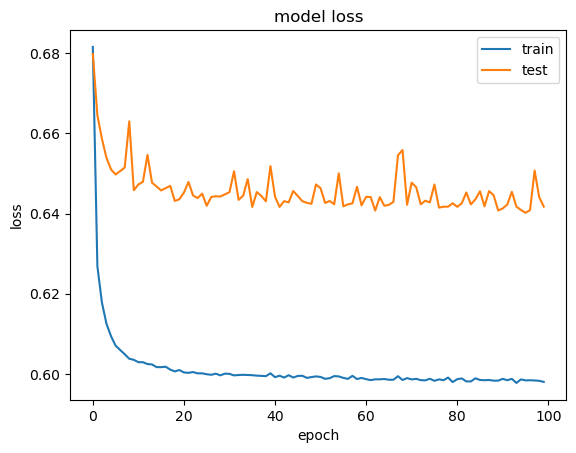

In [24]:
import matplotlib.pyplot as plt

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [25]:
predictions = autoencoder.predict(X_test)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 994us/step


In [27]:
import numpy as np
import pandas as pd

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [28]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.637461,0.001720
std,3.099245,0.041443
min,0.026137,0.000000
25%,0.179877,0.000000
50%,0.312078,0.000000
75%,0.538834,0.000000
max,194.744289,1.000000


# Reconstruction error without fraud

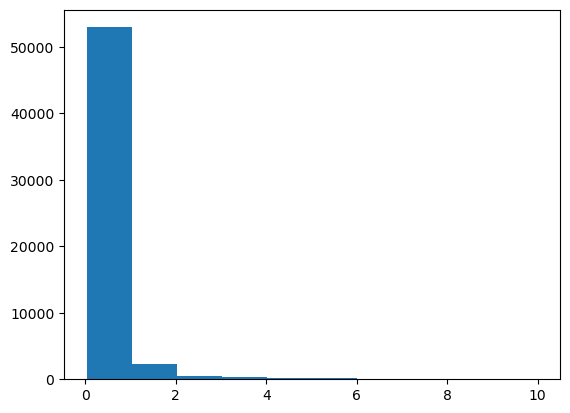

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

# Reconstruction error with fraud

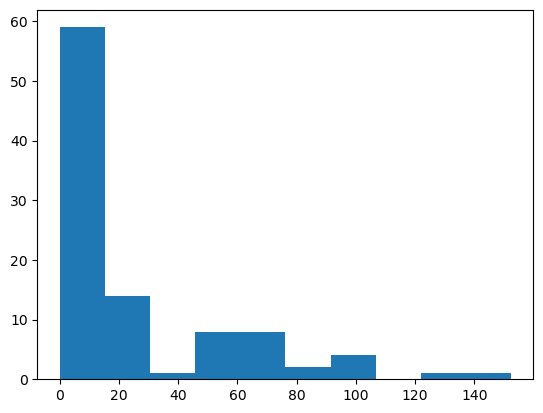

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [31]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. I have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

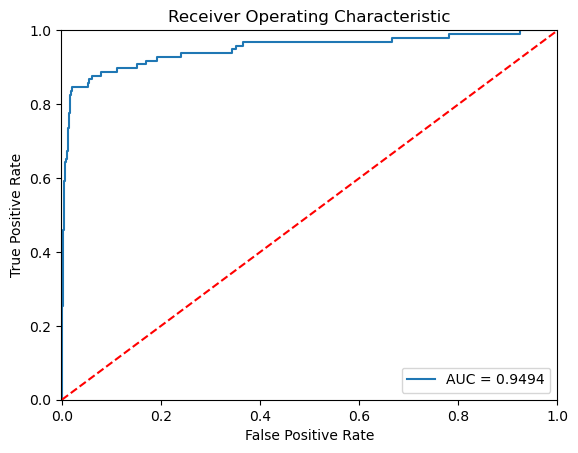

In [32]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. Basically, I want the blue line to be as close as possible to the upper left corner. While our results look pretty good, I have to keep in mind of the nature of our dataset. ROC doesn't look very useful for us. Onward...

# Precision vs Recall

Let's take an example from Information Retrieval in order to better understand what precision and recall are. Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1.

Let's return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low I have the opposite - few returned results with very high relevancy. Ideally, you would want high precision and high recall - many results with that are highly relevant.

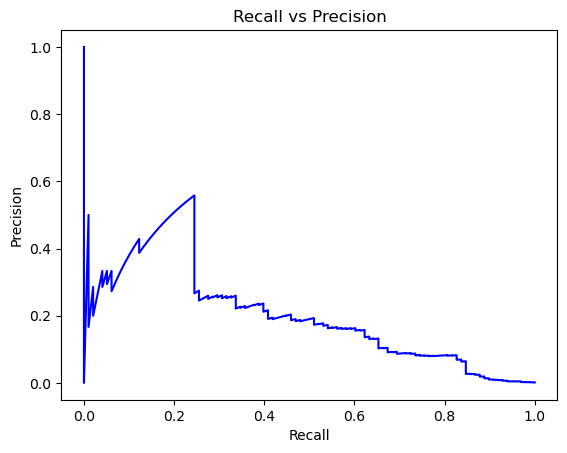

In [33]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

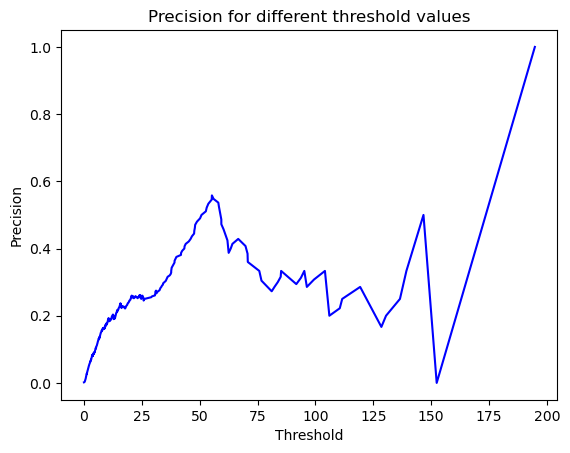

In [34]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

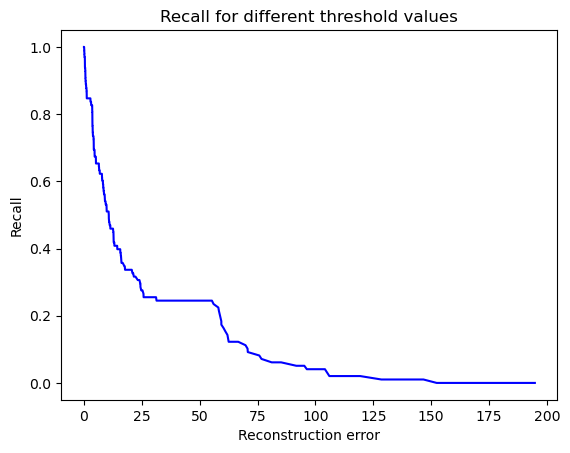

In [35]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, I have the exact opposite situation. As the reconstruction error increases the recall decreases.

# Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But I don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, I'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, I'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [36]:
threshold = 2.9

And see how well I'm dividing the two types of transactions:

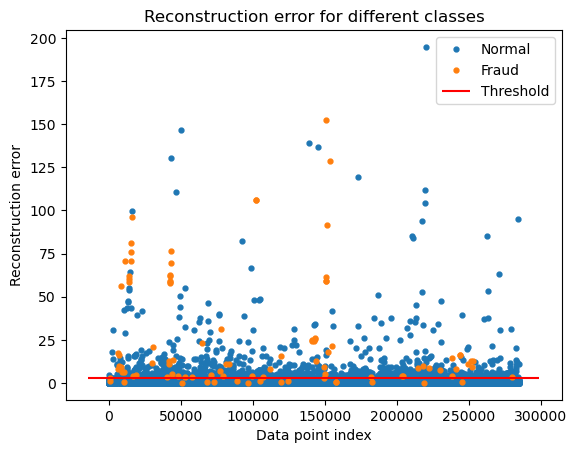

In [37]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

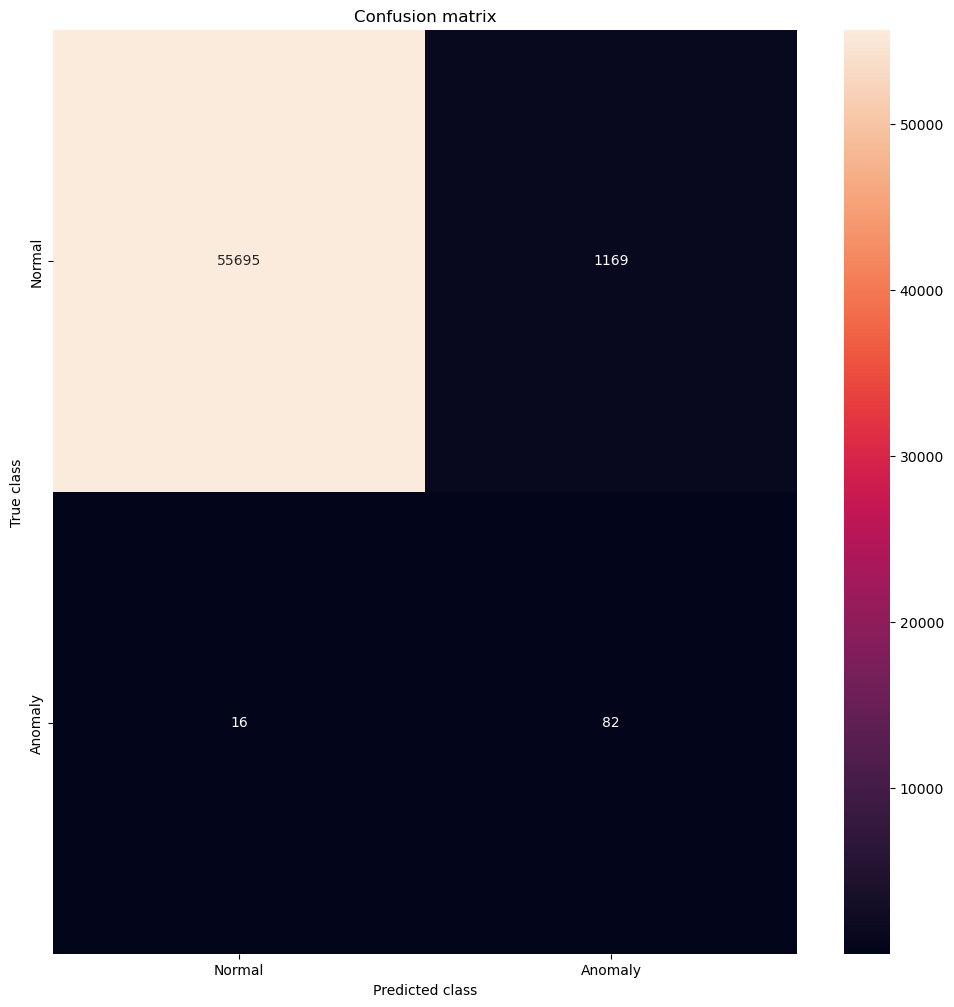

In [41]:
import seaborn as sns  
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix  

LABELS = ['Normal', 'Anomaly']  

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Our model seems to catch a lot of the fraudulent cases. Of course, there is a catch (see what I did there?). The number of normal transactions classified as frauds is really high. Is this really a problem? Probably it is. You might want to increase or decrease the value of the threshold, depending on the problem. That one is up to you.

# Conclusion

I've created a very simple Deep Autoencoder in Keras that can reconstruct what non fraudulent transactions looks like. Initially, I was a bit skeptical about whether or not this whole thing is gonna work out, bit it kinda did. Think about it, I gave a lot of one-class examples (normal transactions) to a model and it learned (somewhat) how to discriminate whether or not new examples belong to that same class. Isn't that cool? Our dataset was kind of magical, though. I really don't know what the original features look like.

Keras gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. You can search for TensorFlow implementations and see for yourself how much boilerplate you need in order to train one. Can you apply a similar model to a different problem?

# References

- Keras Autoencoders: https://blog.keras.io/building-autoencoders-in-keras.html

- Stanford Autoencoders: http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/